In [1]:
import gym
import gym_exchange
import random
import numpy as np
import pandas as pd
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools
import functools
from functools import partial
from copy import deepcopy
import datetime
from itertools import count
import math
import logging
import matplotlib.pyplot as plt
import numpy as np
from random import choice
import time
from reinforcement import device, train_dqn
import seaborn as sns
from collections import deque, Counter
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
os.chdir('..')

%matplotlib inline

--- log folder exists


In [2]:
from gym_engine.utils import iterable

In [3]:
from torch.optim import Adam
from reinforcement import ReplayMemoryWithDone
from reinforcement import TransitionDone
from reinforcement.train import load_game_from_replay_memory, batch_to_tensor

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [6]:
class NormalizedActions(gym.ActionWrapper):
    def lb_ub(self):
        return self.action_space.low, self.action_space.high
    
    def action(self, action):
        lb, ub = self.lb_ub()
        scaled_action = lb + (action + 1.0) * (ub - lb) / 2
        return np.clip(scaled_action, lb, ub)

    def reverse_action(self, scaled_action):
        lb, ub = self.lb_ub()
        action = 2 * (scaled_action - lb) / (ub - lb) - 1
        return np.clip(action, lb, ub)

In [7]:
# Modified, originally from
# https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise:
    def __init__(self, gym_env_action_space, mu=0.0, theta=0.15, 
                 max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        # Discrete, We need gym_env.action_space.n
        # if isinstance(gym_env_action_space, gym.spaces.Discrete):
        #     self.action_dim = gym_env_action_space.n
        # else:
        #     self.action_dim = gym_env_action_space.shape[0]
        self.action_dim   = gym_env_action_space.shape[0]
        # I think low, high should be -1, 1 if normalized in our manner
        # Something to think about ...
        self.low          = gym_env_action_space.low
        self.high         = gym_env_action_space.high
        self.reset()
    
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
    
    def get_noise(self, t=0):
        # update sigma
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) \
                                      * min(1.0, t / self.decay_period)
        x  = self.state
        dx = self.theta * (self.mu - x) \
             + self.sigma * np.random.randn(self.action_dim)
        
        # self.state == noise
        self.state = x + dx
        return np.float32(self.state)

In [24]:
class Actor(nn.Module):
    def __init__(self, num_input, num_hidden, num_action_space):
        super(Actor, self).__init__()
        
        self.s0 = None
        if iterable(num_input):
            len_input = len(num_input)
            if len_input == 2:
                self.s0 = nn.LSTM(num_input[1], num_hidden)
            if len_input == 1:
                num_input = num_input[0]
        
        if self.s0 is None:
            self.s1 = nn.Sequential(
                nn.Linear(num_input, num_hidden),
                nn.LayerNorm(num_hidden),
                nn.ReLU(inplace=True))
        
        self.s2 = nn.Sequential(
            nn.Linear(num_hidden, num_hidden),
            nn.LayerNorm(num_hidden),
            nn.ReLU(inplace=True))
        self.out = nn.Linear(num_hidden, num_action_space)
        # https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py
        # We are doing tanh afterall!
        self.out.weight.data.mul_(0.1)
        self.out.bias.data.mul_(0.1)
    
    def forward(self, x):
        if self.s0:
            x = self.s0(x)[0][:, -1, :]
        else:
            x = self.s1(x)
        x = self.s2(x)
        return F.tanh(self.out(x))
    
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state).detach()
        return action.cpu().numpy()[0]

In [57]:
class Critic(nn.Module):
    def __init__(self, num_input, num_hidden, num_action_space):
        super(Critic, self).__init__()
        
        self.s0 = None
        if iterable(num_input):
            len_input = len(num_input)
            if len_input == 2:
                self.s0 = nn.LSTM(num_input[1], num_hidden)
                # Taking leeway
                #    Note: num_input is used in s1, so doing this...
                num_input = num_hidden
            if len_input == 1:
                num_input = num_input[0]
        
        self.s1 = nn.Sequential(
            nn.Linear(num_input + num_action_space, num_hidden),
            nn.LayerNorm(num_hidden),
            nn.ReLU(inplace=True))

        self.s2 = nn.Sequential(
            nn.Linear(num_hidden, num_hidden),
            nn.LayerNorm(num_hidden),
            nn.ReLU(inplace=True))
        
        self.value = nn.Linear(num_hidden, 1)
        self.value.weight.data.mul_(0.1)
        self.value.bias.data.mul_(0.1)
    
    def forward(self, state, action):
        if self.s0:
            x = self.s0(state)[0][:, -1, :]
        else:
            x = state
        x = torch.cat((x, action), 1)
        x = self.s1(x)
        x = self.s2(x)
        return self.value(x)

In [58]:
class Update:
    @classmethod
    def soft_update(cls, source, target, tau):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) 
                                    + source_param.data * tau)
    @classmethod
    def hard_update(cls, source, target):
        target.load_state_dict(source.state_dict())

In [59]:
class DDPG(nn.Module):
    def __init__(self, num_input, num_hidden, num_action_space, gym_env, args):
        super(DDPG, self).__init__()
        self.args = args
        
        self.actor        = Actor(num_input, num_hidden, num_action_space)
        self.actor_target = Actor(num_input, num_hidden, num_action_space)
        Update.hard_update(self.actor, self.actor_target)

        self.critic        = Critic(num_input, num_hidden, num_action_space)
        self.critic_target = Critic(num_input, num_hidden, num_action_space)
        Update.hard_update(self.critic, self.critic_target)
        
        self.optim_actor  = Adam(self.actor.parameters(), lr=args.actor_lr)
        self.optim_critic = Adam(self.critic.parameters(), lr=args.critic_lr)
        
        # add options through args at some point
        self.noise = OUNoise(gym_env.action_space)

        self.value_loss_fn = nn.MSELoss()
    
    def select_action(self, state, t=0):
        self.actor.eval()
        # should detach from here...
        action = self.actor.select_action(state)
        action += self.get_noise(t)
        self.actor.train()
        return np.clip(action, -1.0, 1.0)
    
    def select_action_numpy(self, state, t=0):
        return self.select_action(state, t)
    
    def reset_noise(self):
        self.noise.reset()
    
    def get_noise(self, t):
        return self.noise.get_noise(t)
    
    def get_policy_loss(self, state):
        action = self.actor(state)
        return -self.critic(state, action).mean()
    
    def get_value_loss(self, state, action, reward, next_state, done):
        next_action = self.actor_target(next_state).detach()
        target_value = self.critic_target(next_state, next_action).detach()
        expected_value = (reward + (1.0 - done) \
                                   * target_value * self.args.gamma).cuda()

        pred_value = self.critic(state, action)

        value_loss = self.value_loss_fn(pred_value, expected_value)
        return value_loss
    
    def forward(self, x):
        raise NotImplementedError
    
    def soft_update(self, value_loss, policy_loss):
        
        self.optim_critic.zero_grad()
        value_loss.backward()
        self.optim_critic.step()

        self.optim_actor.zero_grad()
        policy_loss.backward()
        self.optim_actor.step()

        Update.soft_update(self.critic, self.critic_target, self.args.tau)
        Update.soft_update(self.actor, self.actor_target, self.args.tau)
        

In [60]:
def plot(idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame {}, reward: {}'.format(idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [61]:
# Wonder if I should wrap this into a class...
def train_ddpg(ddpg_agent, replay_buffer, batch_size, num_iteration=0):

    if len(replay_buffer) < batch_size * 10:
        return
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
    
    value_loss  = ddpg_agent.get_value_loss(state, action, reward, next_state, done)
    policy_loss = ddpg_agent.get_policy_loss(state)
     
    # This can't be the best way...
    # Need to think about what's the best design...
    ddpg_agent.soft_update(value_loss, policy_loss)

In [62]:
import gym_exchange

In [63]:
# env = NormalizedActions(gym.make("game-stock-exchange-continuous-v0"))
env = NormalizedActions(gym.make("Pendulum-v0"))
# env = NormalizedActions(gym.make("CartPole-v1")) # def:= env.action_space.n 
ou_noise = OUNoise(env.action_space)

state_dim  = env.observation_space.shape
action_dim = env.action_space.shape[0]
hidden_dim = 256

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/wbaik/Code/library/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [76]:
class Args:
    def __init__(self):
        self.actor_lr = 1e-3
        self.critic_lr = 1e-3
        self.gamma = 0.99
        self.tau = 1e-2
        
args = Args()

In [77]:
ddpg_agent = DDPG(state_dim, hidden_dim, action_dim, env, args).cuda()

In [71]:
rm = ReplayBuffer(1000000)

In [78]:
def main():
    BATCH_SIZE = 128
    N_EPISODE = 120
    MAX_STEP = 1000
    rewards = []

    for cur_iter in range(1, N_EPISODE+1):
        state = env.reset()
        ddpg_agent.reset_noise()
        episode_reward = 0

        for step in range(MAX_STEP):
            action = ddpg_agent.select_action_numpy(state, step)
            next_state, reward, done, _ = env.step(action)
            rm.push(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward

            train_ddpg(ddpg_agent, rm, BATCH_SIZE)
            if cur_iter % 40 == 0:
                plot(cur_iter, rewards)

            if done:
                print('\rCurrent Episode No.{}, Episode reward: {}'.format(
                    cur_iter, episode_reward), end='')
                break

        rewards.append(episode_reward)

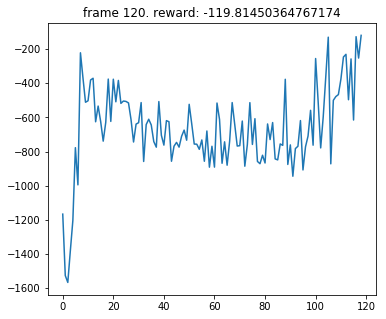

Current Episode No.120, Episode reward: -631.364132775325

In [79]:
%load_ext line_profiler
%lprun -f main main()